In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!pip install git+https://github.com/omarcastano/MasterThesis.git

In [ ]:
#!cp -r '/content/drive/MyDrive/Maestria/Datasets/LabelsGeoTiffv2.7z' /content
#!7z x "/content/LabelsGeoTiffv2.7z"
#!cp -r '/content/drive/MyDrive/Maestria/Datasets/Dataset.7z' /content
#!7z x "/content/Dataset.7z"

In [1]:
from MasterThesis import EDA
import pandas as pd

from MasterThesis.regression import CustomDataset
from MasterThesis.regression.utils import visualize_augmented_images
from MasterThesis.classification.utils import generate_metadata_train_test_stratified_cv
from MasterThesis.trainer import Trainer

import wandb

wandb.login(key="3dfb06e1099f6465f340f29f3fbd268fac8216e2")
os.environ["WANDB_SILENT"] = "true"

/media/omar/storage/gdrive/Maestria/MasterThesis/MasterThesis/preprocessing.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
drive_path = "/media/omar/storage/gdrive/"
drive_path = "/media/omar/storage/gdrive"

In [2]:

path_to_labels = f"{drive_path}Maestria/Datasets/LabelsGeoTiffv2/"
path_to_images = f"{drive_path}Maestria/Datasets/Dataset/"
select_classes = ["non_agricultural_area", "agricultural_frontier"] # ["non_agricultural_area", "legal_exclusions", "agricultural_frontier"]
target_column = ["non_agricultural(km2)", "agricultural_frontier(km2)"]
image_column = "Image"

In [3]:
query = ["((legal_exclusions == 0) and ((non_agricultural == 1) or (agricultural_frontier == 1))) "]
# "| ((legal_exclusions == 1) and (non_agricultural == 0) and (agricultural_frontier == 0))"]

In [4]:
# Load metadata
path_to_metadata = f"{drive_path}Maestria/Datasets/metadata.csv"
metadata = pd.read_csv(path_to_metadata).sample(frac=0.25, random_state=42)
metadata["Labels"] = (metadata["non_agricultural(km2)"] <= 0.5)*1
metadata = metadata.query(query[0])

print(metadata.shape)
metadata.head()

(11899, 11)


,Id,Elevation,Image,Mask,non_agricultural(km2),agricultural_frontier(km2),legal_exclusions(km2),non_agricultural,legal_exclusions,agricultural_frontier,Labels
27030,181810200900132113,"18NVN/18NVN_1_0/(200, 900)/elevation.tif","18NVN/18NVN_1_0/(200, 900)/chip.npy","18NVN/18NVN_1_0/(200, 900)/mask.tif",0.062,0.938,0.0,1,0,1,1
23748,181851400700132112,"18NVM/18NVM_5_1/(400, 700)/elevation.tif","18NVM/18NVM_5_1/(400, 700)/chip.npy","18NVM/18NVM_5_1/(400, 700)/mask.tif",0.504,0.496,0.0,1,0,1,0
11740,181828300900132015,"18NUP/18NUP_2_8/(300, 900)/elevation.tif","18NUP/18NUP_2_8/(300, 900)/chip.npy","18NUP/18NUP_2_8/(300, 900)/mask.tif",0.000,1.000,0.0,0,0,1,1
4543,181894400300132012,"18NUM/18NUM_9_4/(400, 300)/elevation.tif","18NUM/18NUM_9_4/(400, 300)/chip.npy","18NUM/18NUM_9_4/(400, 300)/mask.tif",0.034,0.966,0.0,1,0,1,1
4657,181896500700132012,"18NUM/18NUM_9_6/(500, 700)/elevation.tif","18NUM/18NUM_9_6/(500, 700)/chip.npy","18NUM/18NUM_9_6/(500, 700)/mask.tif",0.191,0.809,0.0,1,0,1,1


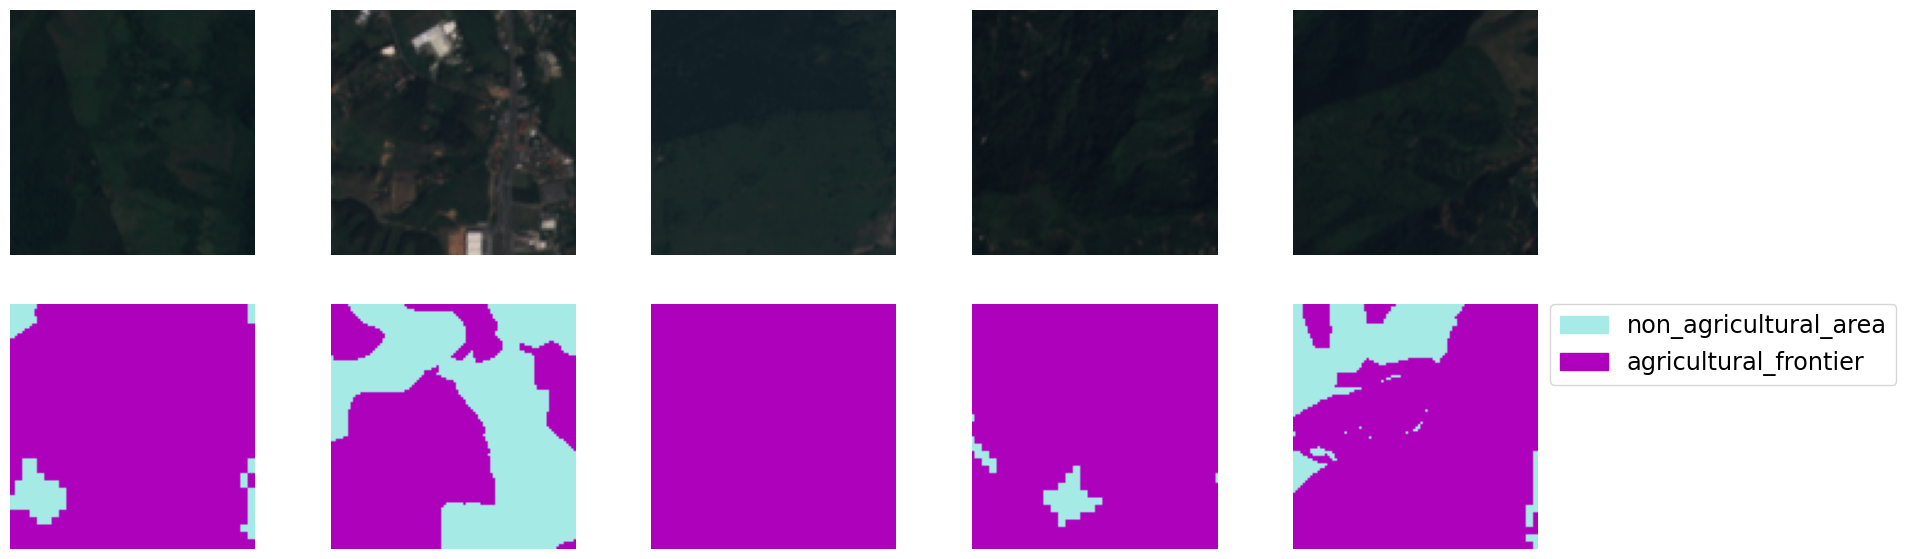

In [5]:
# Plot images
fig = EDA.visualize_images_and_masks(
    path_to_labels, path_to_images, metadata, temporal_dim=False, n=5, figsize=(20, 7), class_names=select_classes
)

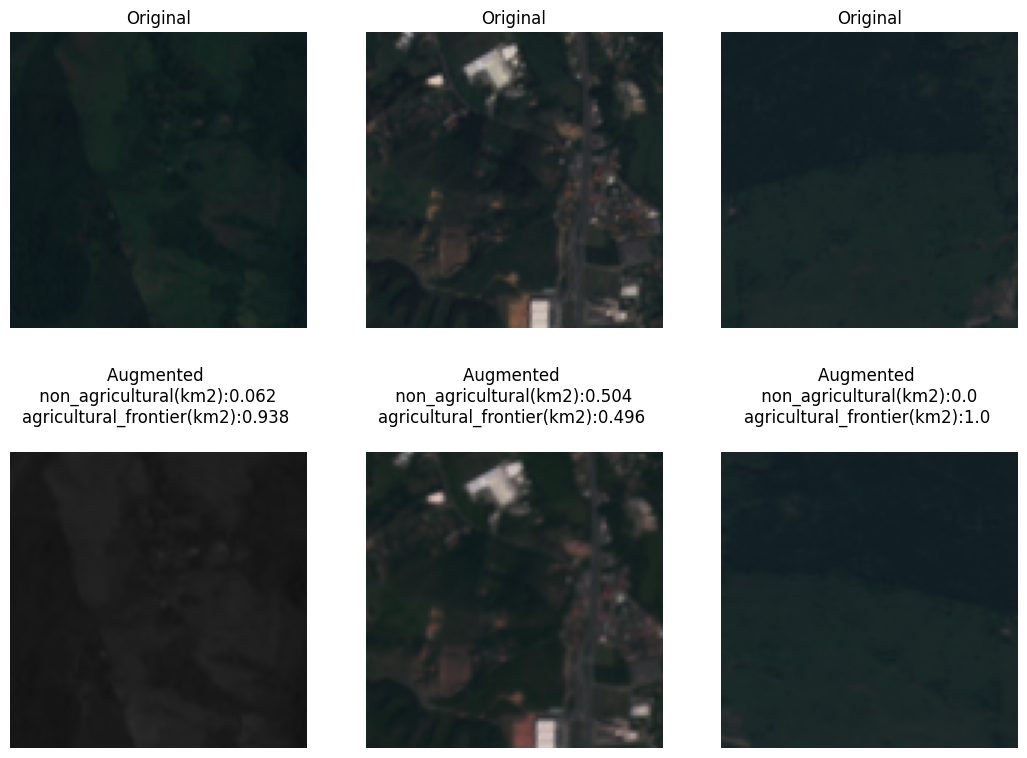

In [6]:
augment = {
    "horizontal_flip_prob": 0.5,
    "vertical_flip_prob": 0.5,
    "resize_scale": (0.8, 1.0),
    "resize_prob": 0.5,
    "brightness": 0.1,
    "contrast": 0.1,
    "saturation": 0.1,
    "hue": 0.1,
    "color_jitter_prob": 0.5,
    "gray_scale_prob": 0.2,
}

ds = CustomDataset(path_to_images, metadata, target_column, image_column, return_original=True, augment=augment)
visualize_augmented_images(ds, col_target=target_column, n=3, figsize=(13, 10))

In [7]:
augment = {
    "horizontal_flip_prob": 0.5,
    "vertical_flip_prob": 0.5,
    "resize_scale": (0.8, 1.0),
    "resize_prob": 0.5,
    "brightness": 0.1,
    "contrast": 0.1,
    "saturation": 0.1,
    "hue": 0.1,
    "color_jitter_prob": 0.2,
    "gray_scale_prob": 0.2,
}

In [8]:
metadata_train, metadata_test, metadata_valid = generate_metadata_train_test_stratified_cv(metadata, train_size=10, n_split=5)

Number fo total images : 11899
Number of images to train: 10, 0.084%
Number of images to test: 2380, 20.002%
Number of images to valid: 2380, 20.002%


In [9]:
def run_experiment(
    train_size,
    epochs,
    pretrained=False,
    version="RandomInit",
    path_to_load_backbone=None,
    fine_tune=False,
    ft_epoch=30,
    train_batch_size=8,
):

    metadata_train, metadata_test, metadata_valid = generate_metadata_train_test_stratified_cv(metadata, train_size=train_size, n_split=5)

    hypm_kwargs = {
        "version": version,
        "model_name": "Regressor",
        "amount_of_ft_data": metadata_train[1].shape[0],
        "backbone": "resnet18",
        "pretrained": pretrained,
        "fine_tune": fine_tune,
        "ft_epoch": ft_epoch,
        "ft_lr": 0.00005,
        "in_channels": 3,
        "output_size": 2,
        "class_names": select_classes,
        "normalizing_factor": 6000,
        "weight_decay": 0.00005,
        "learning_rate": 1e-3,
        "train_batch_size": train_batch_size,
        "test_batch_size": 128,
        "epochs": epochs,
        "augment_train": augment,
        "augment_test": None,
        "patient": 20,
        "eval_epoch": 1,
    }

    wandb_kwargs = {
        "project": "Regression-2_classes",
        "entity": "omar-c",
        "id": None,
        "name": version,
        "resume": False,
    }

    for train, test, valid in zip(metadata_train, metadata_test, metadata_valid):
        metadata_kwargs = {
            "path_to_images": path_to_images,
            "path_to_save_model": None,  # path_to_save_model,  # Path to save the model that is being trained (do not include the extension .pt or .pth)
            "path_to_load_model": None,  # Path to load a model from a checkpoint (useful to handle notebook disconection)
            "path_to_load_backbone": path_to_load_backbone,
            "metadata_train": train,
            "metadata_test": test,
            "metadata_valid": valid,
            "target_column": target_column,
            "image_column": image_column,
            "num_workers": 6,
            "device": "cuda",
        }
        trainer = Trainer(CustomDataset, visualize_augmented_images, wandb_kwargs, hypm_kwargs, metadata_kwargs)
        trainer.configure_trainer()

        trainer.fit()

In [ ]:
path_to_save_model = f"{drive_path}Maestria/pruebas/models/resnet18"
path_to_load_backbone_simclr = f"{drive_path}Maestria/Theses/SSL/SimCLR/models/resnet18/model_SSL-SimCLR-v2.pth"
path_to_load_backbone_elevation_simclr = f"{drive_path}Maestria/Theses/SSL/ElevationSSL/models/resnet18/Elevation-SimCLR/model_SimCLR-Elevation.pth"
path_to_load_backbone_elevation = f"{drive_path}Maestria/Theses/SSL/ElevationSSL/models/resnet18/Elevation/model_Elevation.pth"

In [ ]:
for i in [10, 20, 40, 80]:

    run_experiment(
       train_size=i,
       epochs=100,
       pretrained=False,
       version="RandomInit",
       path_to_load_backbone=None,
       fine_tune=False,
       ft_epoch=None,
       train_batch_size=5,
    )

    run_experiment(
       train_size=i,
       epochs=100,
       pretrained=True,
       version="SimCLR",
       path_to_load_backbone=path_to_load_backbone_simclr,
       fine_tune=True,
       ft_epoch=5,
       train_batch_size=5,
    )

    run_experiment(
       train_size=i,
       epochs=100,
       pretrained=True,
       version="Elevation+SimCLR",
       path_to_load_backbone=path_to_load_backbone_elevation_simclr,
       fine_tune=True,
       ft_epoch=5,
       train_batch_size=5,
    )

    run_experiment(
        train_size=i,
        epochs=100,
        pretrained=True,
        version="Elevation",
        path_to_load_backbone=path_to_load_backbone_elevation,
        fine_tune=True,
        ft_epoch=5,
        train_batch_size=5,
    )

In [ ]:
for i in [100, 200, 500]:

    run_experiment(
       train_size=i,
       epochs=100,
       pretrained=False,
       version="RandomInit",
       path_to_load_backbone=None,
       fine_tune=False,
       ft_epoch=None,
       train_batch_size=16,
    )

    run_experiment(
       train_size=i,
       epochs=100,
       pretrained=True,
       version="SimCLR",
       path_to_load_backbone=path_to_load_backbone_simclr,
       fine_tune=True,
       ft_epoch=10,
       train_batch_size=16,
    )

    run_experiment(
       train_size=i,
       epochs=100,
       pretrained=True,
       version="Elevation+SimCLR",
       path_to_load_backbone=path_to_load_backbone_elevation_simclr,
       fine_tune=True,
       ft_epoch=10,
       train_batch_size=16,
    )

    run_experiment(
        train_size=i,
        epochs=100,
        pretrained=True,
        version="Elevation",
        path_to_load_backbone=path_to_load_backbone_elevation,
        fine_tune=True,
        ft_epoch=10,
        train_batch_size=16,
    )

In [ ]:
for i in [1000, 2000, 3000]:

    run_experiment(
       train_size=i,
       epochs=100,
       pretrained=False,
       version="RandomInit",
       path_to_load_backbone=None,
       fine_tune=False,
       ft_epoch=None,
       train_batch_size=32,
    )

    run_experiment(
       train_size=i,
       epochs=100,
       pretrained=True,
       version="SimCLR",
       path_to_load_backbone=path_to_load_backbone_simclr,
       fine_tune=True,
       ft_epoch=10,
       train_batch_size=32,
    )

    run_experiment(
       train_size=i,
       epochs=100,
       pretrained=True,
       version="Elevation+SimCLR",
       path_to_load_backbone=path_to_load_backbone_elevation_simclr,
       fine_tune=True,
       ft_epoch=10,
       train_batch_size=32,
    )

    run_experiment(
        train_size=i,
        epochs=100,
        pretrained=True,
        version="Elevation",
        path_to_load_backbone=path_to_load_backbone_elevation,
        fine_tune=True,
        ft_epoch=10,
        train_batch_size=32,
    )